In [1]:
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
from itertools import product
from tqdm import tqdm

In [2]:
def make_random_signal(n_comp=20, n_time=200):
  """
  Make a random signal with n_comp sine components.

  Args:
    n_comp (int): number of sine components
    n_time (int): number of time points
  """
  A = np.random.uniform(0, 1, size=(n_comp, 1))
  T = np.random.uniform(15, 35, size=(n_comp, 1))
  P = np.random.uniform(0, 2*np.pi, size=(n_comp,1))
  X = A * np.sin(2 * np.pi * np.arange(n_time).reshape(1, n_time) / T + P)
  result = np.sum(X, axis=0)
  return result

def correlation(x, y):
  rho, p = spearmanr(x, y)
  return rho

def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

n_comp = 20 # assume 20 sine components
n_time = 200 # assume 200 time points
n_shuffle = 999 # assume 999 shuffled time series for each test
np.random.seed(1)

Line 517: Let $M$ be a $2 \times n$ matrix representing a time series of relative abundances of two taxa, i and j. The rows of $M$ correspond to taxa i and j, and the columns represent the chronologically ordered time points t=1,...,n.

In [3]:
# i and j are the time series of species abundance. Let's ignore the CLR business for now.
i = make_random_signal(n_time = n_time)
j = make_random_signal(n_time = n_time)

print(autocorr1(i, range(20)))
print(autocorr1(j, range(20)))

# M would be a matrix whose first row is i and whose second row is j

[ 1.          0.97014364  0.88258434  0.74322441  0.56155379  0.35009205
  0.12347784 -0.10277561 -0.31370082 -0.49624055 -0.64034462 -0.7396563
 -0.79172044 -0.79772278 -0.76185623 -0.69048142 -0.59126487 -0.47242415
 -0.34211921 -0.20795955]
[ 1.          0.95638282  0.82992724  0.63684662  0.40261736  0.1556466
 -0.07838855 -0.27937598 -0.43303677 -0.53037574 -0.56790508 -0.54892682
 -0.48457387 -0.39269761 -0.29404978 -0.20745044 -0.14623463 -0.11679848
 -0.11858928 -0.14478206]


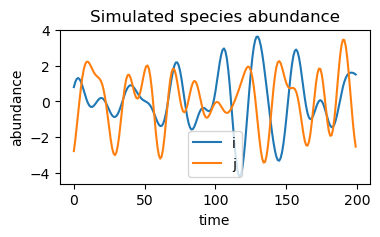

In [4]:
# Let's plot it
plt.figure(figsize=[4,2])
plt.plot(i); plt.plot(j)
plt.xlabel('time'); plt.ylabel('abundance'); plt.title('Simulated species abundance')
plt.legend(['i', 'j'])
plt.show()

Line 519: The empirically observed Spearman coefficient is calculated as $\rho(\Delta i_t, j_t)$ where $\Delta i_t = i_{t+1} - t_t$.

In [5]:
def lag_correlation(i, j):
  delta_i = np.diff(i) # Δi
  return correlation(delta_i, j[:-1]) # ρ(Δi, j)

rho_obs = lag_correlation(i, j)
print(rho_obs)

0.347166133698797


Line 526: Essentially, this text says that we let $\sigma(1),...,\sigma(n)$ be some permutation of the sequence $\{1,...,n\}$, and we generate null time series as

$$ i_{\sigma(t)} = i_{\sigma(1)}, ..., i_{\sigma(n)} $$
$$ j_{\sigma(t)} = j_{\sigma(1)}, ..., j_{\sigma(n)} $$

The key is that the same choice of $\sigma$ is used for $i$ and $j$.

Line 533: Thus, the permuted Spearman coefficient is then defined as:

$$\rho (\Delta i_{\sigma(t)}, j_{\sigma(t)})$$

where $\Delta i_{\sigma(t)} = i_{\sigma(t+1)} - i_{\sigma(t)}$

In [6]:
def get_null_distribution(i, j, n_shuffle):
  rho_shuffle = np.zeros(n_shuffle)
  for shuffle_idx in range(n_shuffle):
    sigma = np.random.permutation(i.size) # generate sigma once (e.g. Line 526)
    i_sigma = i[sigma] # permute i
    j_sigma = j[sigma] # permute j
    rho_shuffle[shuffle_idx] = lag_correlation(i_sigma, j_sigma) # ρ(Δi, j) per Line 534
  return rho_shuffle

rho_shuffle = get_null_distribution(i, j, n_shuffle)

Let's see if this method detects a correlation. Hopefully it doesn't, because i and j were produced totally independently of each other, with independent amplitudes, independent periods, and independent phases.

Line 537: To determine whether calculated Spearman coefficients were more extreme than chance expectation, we compared them to a null distribution which was generated by permuting the time series and recalculating the corresponding Spearman coefficient

I'm going to interpret "more extreme" as having a greater absolute value.

In [7]:
p = (np.sum( np.abs(rho_shuffle) >= np.abs(rho_obs)) + 1) / (n_shuffle + 1)
print(f"p = {p}")

p = 0.001


Hmmm, The p-value is very low, meaning that it reported a significant correlation, even though the two time series are independent. So the test got it wrong in this case. But let's be systematic and repeat this test several times to get a false positive rate.



In [8]:
def run_n_trials(n_trials=40, 
                 n_time=200, 
                 n_shuffle=999, 
                 seed=1,
                 i_n_comp=20,
                 j_n_comp=20,
                 disable_tqdm=True):
  
  np.random.seed(seed)
  pvals = np.zeros(n_trials)
  for trial_idx in tqdm(range(n_trials), disable=disable_tqdm):
    i = make_random_signal(n_time = n_time, n_comp=i_n_comp)
    j = make_random_signal(n_time = n_time, n_comp=j_n_comp)
    rho_obs = lag_correlation(i, j)
    rho_shuffle = get_null_distribution(i, j, n_shuffle)
    p = (np.sum( np.abs(rho_shuffle) >= np.abs(rho_obs)) + 1) / (n_shuffle + 1)
    pvals[trial_idx] = p
  return pvals

# Parallelize the trials

def process_combination(i_n_comp, j_n_comp, n_trials, n_time, n_shuffle, seed):
    pvals = run_n_trials(
        n_trials=n_trials,
        n_time=n_time,
        n_shuffle=n_shuffle,
        seed=seed,
        i_n_comp=i_n_comp,
        j_n_comp=j_n_comp,
        disable_tqdm=True,
    )
    return [i_n_comp, j_n_comp, pvals]

def parameter_sweep(i_n_comp_range, j_n_comp_range, n_jobs=-1, n_trials=40, n_time=200, n_shuffle=999, seed=1):
    # Create all combinations of i_n_comp and j_n_comp
    param_combinations = list(product(i_n_comp_range, j_n_comp_range))
    
    # Use tqdm for progress monitoring
    with tqdm(total=len(param_combinations)) as progress_bar:
        # Use joblib to parallelize the parameter sweep
        swept_pvals = Parallel(n_jobs=n_jobs)(
            delayed(process_combination)(
                i_n_comp, 
                j_n_comp, 
                n_trials, 
                n_time, 
                n_shuffle, 
                seed
            ) for i_n_comp, j_n_comp in param_combinations
        )
        progress_bar.update(len(param_combinations))
    
    return swept_pvals

swept_pvals = parameter_sweep(range(1, 21), range(1, 21), n_jobs=8)

100%|██████████| 400/400 [33:45<00:00,  5.06s/it]


<Axes: xlabel='i_n_comp'>

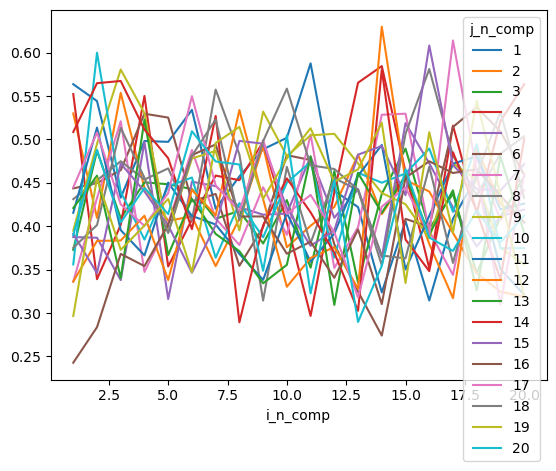

In [9]:
# take the mean of the p-values
# third element of every row is the vector of p-values
avg_pvals = pd.DataFrame([(i[0], i[1], i[2].mean()) for i in swept_pvals])
avg_pvals.columns = ['i_n_comp', 'j_n_comp', 'avg_pval']
#fpr = np.mean(pvals <= 0.05)
#print(f"False positive rate = {fpr}")
avg_pvals.pivot(index='i_n_comp',columns='j_n_comp', values='avg_pval').plot()


Oh dear... The false positive rate is 0.35

That means, I produced a pair of totally independent time series, and this test thought there was a significant lagged correlation more than a third of the time!

This is cause for concern.

As a "positive control" let's compare to a standard method. We'll use the IAAFT implementation in Pyunicorn.

In [10]:
! pip install pyunicorn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 13.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00
  Created wheel for pyunicorn: filename=pyunicorn-0.8.0-cp39-cp39-macosx_11_0_arm64.whl size=561977 sha256=8a00a35dcb5f0a33312268c3bcc67eab227b50e63a464548a0dc320f6182e7b8
  Stored in directory: /Users/laurielyon/Library/Caches/pip/wheels/c1/77/c5/3fe2b515153f19f0df4d9553387aab259947f3d2565d46e25c
Successfully built pyunicorn


In [11]:
from pyunicorn.timeseries.surrogates import Surrogates

n_time = 200 # assume 100 time points
n_shuffle = 999 # assume 999 shuffled time series for each test
n_trials = 40 # try 40 trials to estimate the false positive rate.
np.random.seed(1)

pvals = np.zeros(n_trials)
for trial_idx in tqdm(range(n_trials)):
  i = make_random_signal(n_time = n_time)
  j = make_random_signal(n_time = n_time)
  rho_obs = lag_correlation(i, j)
  rho_shuffle = np.zeros(n_shuffle)
  for surr_idx in range(n_shuffle):
    surrogate_maker = Surrogates(original_data=j.reshape(1,-1), silence_level=2)
    surr = surrogate_maker.refined_AAFT_surrogates(n_iterations=10, output='true_spectrum')
    j_surr = surr.ravel()
    rho_shuffle[surr_idx] = lag_correlation(i, j_surr)
  p = (np.sum( np.abs(rho_shuffle) >= np.abs(rho_obs)) + 1) / (n_shuffle + 1)
  pvals[trial_idx] = p

100%|██████████| 40/40 [18:29<00:00, 27.73s/it]  


In [12]:
fpr = np.mean(pvals <= 0.05)
print(f"False positive rate = {fpr}")

False positive rate = 0.075


This FPR is perhaps still not perfect, but its a lot more reasonable.

So it doesn't seem like I just created an impossible task, and the shuffling method tends to have crazy high FPR compared to something you can pick up off the shelf.